# Time Travel

In a typical chatbot workflow, the users interacts with the bot one or more times to accomlish a task. Memory and a human-in-the-loop enable checkpoints in the graph state and control future responses.

What if you want a user to be able to start from a previous response and explore a different outcome> Or what if you want users to be able to rewind your chatbot's work to fix mistakes or try a different strategy, something that is common in applications like autonomous software engineers?

You can create these types of experiences using langgraph's built-in **time travel** functionality

## 1. Rewind your graph

Rewind your graph by fetching a checkpoint using the graph's `get_state_history` method. You can then resume execution at this previous point in time

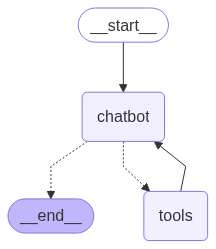

In [1]:
import os
from typing import Annotated, TypedDict, Sequence
from langchain.chat_models import init_chat_model
from langchain_core.messages import BaseMessage
from langchain_tavily import TavilySearch

from langgraph.graph import StateGraph, START, END
from langgraph.prebuilt import ToolNode, tools_condition
from langgraph.graph.message import add_messages
from langgraph.checkpoint.memory import MemorySaver

from IPython.display import Image, display

class AgentState(TypedDict):
    messages: Annotated[Sequence, add_messages]


tool = TavilySearch(max_results=2)
tools = [tool]

llm = init_chat_model("ollama:llama3.2")
llm_with_tools = llm.bind_tools(tools)


def chatbot(state: AgentState) -> AgentState:
    response = llm_with_tools.invoke(state.get("messages"))
    return {"messages": [response]}

tool_node = ToolNode(tools)

graph_builder = StateGraph(AgentState)
graph_builder.add_node("chatbot", chatbot)
graph_builder.add_node("tools", tool_node)

graph_builder.add_edge(START, "chatbot")
graph_builder.add_edge("tools", "chatbot")

graph_builder.add_conditional_edges("chatbot", tools_condition)

memory = MemorySaver()

graph = graph_builder.compile(checkpointer=memory)


# display the graph
display(Image(graph.get_graph().draw_mermaid_png()))

## 2. ADD Steps
Add steps to your graoh. Every step will be checkpointed in its state history

In [2]:
config = {"configurable":{"thread_id":"1"}}

initial_state = {
    "messages":[
        {
            "role": "user",
            "content": (
                "I'm Learning LangGraph. "
                "Could you do some research on it for me?"
            )
        }
    ]
}

events = graph.stream(initial_state, config=config, stream_mode="values")

for event in events:
    if "messages" in event:
        event.get("messages")[-1].pretty_print()

================================ Human Message =================================

I'm Learning LangGraph. Could you do some research on it for me?
================================== Ai Message ==================================
Tool Calls:
  tavily_search (4f69240b-64b9-4ccd-9600-5e8133f4d829)
 Call ID: 4f69240b-64b9-4ccd-9600-5e8133f4d829
  Args:
    include_domains: None
    include_images: False
    query: LangGraph research
    search_depth: advanced
    time_range: None
    topic: general
================================= Tool Message =================================
Name: tavily_search

{"query": "LangGraph research", "follow_up_questions": null, "answer": null, "images": [], "results": [{"url": "https://docs.gptr.dev/docs/gpt-researcher/multi_agents/langgraph", "title": "LangGraph - GPT Researcher", "content": "![GPT Researcher](/img/gptr-logo.png)\n![GPT Researcher](/img/gptr-logo.png)\n\n# LangGraph\n\n[LangGraph](https://python.langchain.com/docs/langgraph) is a library for 

In [3]:
initial_state = {
    "messages":[
        {
            "role": "user",
            "content": (
                "Ya that's helpful. Maybe I'll "
                "build an autonomous agent with it!"
            )
        }
    ]
}


events = graph.stream(initial_state, config=config, stream_mode="values")

for event in events:
    if "messages" in event:
        event.get("messages")[-1].pretty_print()

================================ Human Message =================================

Ya that's helpful. Maybe I'll build an autonomous agent with it!
================================== Ai Message ==================================
Tool Calls:
  tavily_search (18892f3e-38ef-40f4-91da-5058494572d0)
 Call ID: 18892f3e-38ef-40f4-91da-5058494572d0
  Args:
    include_domains: None
    include_images: False
    query: building autonomous agent with LangGraph
    search_depth: advanced
    time_range: None
    topic: general
================================= Tool Message =================================
Name: tavily_search

{"query": "building autonomous agent with LangGraph", "follow_up_questions": null, "answer": null, "images": [], "results": [{"url": "https://www.amazon.com/Building-Autonomous-Agents-LangGraph-Developers/dp/B0DVR7LL3G", "title": "Building Autonomous AI Agents with LangGraph: A Developer's Guide", "content": "Building Autonomous AI Agents with LangGraph: A Developer’s Guide 

## 3. Reply the full state history
Now that you have added steps to the chatbot, you can `reply` the full state history to see everything that occurred.

In [5]:
to_reply = None

for state in graph.get_state_history(config=config):
    print(f"Num Messages: {len(state.values['messages'])}, Next: {state.next}")
    print("-" * 80)

    if len(state.values['messages']) == 6:
        to_reply = state

Num Messages: 8, Next: ()
--------------------------------------------------------------------------------
Num Messages: 7, Next: ('chatbot',)
--------------------------------------------------------------------------------
Num Messages: 6, Next: ('tools',)
--------------------------------------------------------------------------------
Num Messages: 5, Next: ('chatbot',)
--------------------------------------------------------------------------------
Num Messages: 4, Next: ('__start__',)
--------------------------------------------------------------------------------
Num Messages: 4, Next: ()
--------------------------------------------------------------------------------
Num Messages: 3, Next: ('chatbot',)
--------------------------------------------------------------------------------
Num Messages: 2, Next: ('tools',)
--------------------------------------------------------------------------------
Num Messages: 1, Next: ('chatbot',)
--------------------------------------------------

Checkpoints are  saved for every step of the graph. This **spans invocations** so you can rewind across a full thread's history.

### Resume from a checkpoint
Resume from the `to_reply` state, wchih is after the `chatbot` node in the seconf graph invocation. Resuming from this point will call the action node next.

In [6]:
print(to_reply.next)
print(to_reply.config)

('tools',)
{'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1f049c1e-e38f-6982-8006-e8680494f241'}}


## 4. Load the state from the moment-in-time

The checkpoint's `to_reply.config` contains a `checkpoint_id` timestamp. Providing this `checkpoint_id` value tells LangGraph's checkpointer to **load** the state from that moment in time

In [7]:
for event in graph.stream(None, to_reply.config, stream_mode="values"):
    if "messages" in event:
        event.get("messages")[-1].pretty_print()

================================== Ai Message ==================================
Tool Calls:
  tavily_search (18892f3e-38ef-40f4-91da-5058494572d0)
 Call ID: 18892f3e-38ef-40f4-91da-5058494572d0
  Args:
    include_domains: None
    include_images: False
    query: building autonomous agent with LangGraph
    search_depth: advanced
    time_range: None
    topic: general
================================= Tool Message =================================
Name: tavily_search

{"query": "building autonomous agent with LangGraph", "follow_up_questions": null, "answer": null, "images": [], "results": [{"url": "https://www.amazon.com/Building-Autonomous-Agents-LangGraph-Developers/dp/B0DVR7LL3G", "title": "Building Autonomous AI Agents with LangGraph: A Developer's Guide", "content": "Building Autonomous AI Agents with LangGraph: A Developer’s Guide is the ultimate resource for developers who want to harness the power of modern graph-based AI. This comprehensive guide demystifies LangGraph and 

The graph resumed execution from the `action` node. You can tell this is the case since the first value printed above is the response from our search engine tool.
